In [ ]:
#Project Members - Shwetha Tinnium Raju and Shreshta Mohan

**Importing required packages**

In [ ]:
import numpy as np
import pandas as pd
import nltk
import re
import seaborn as sns
from sklearn import preprocessing
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import TruncatedSVD
from dataclasses import replace
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_selection import chi2
from sklearn.cluster import KMeans
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_selection import SelectKBest, chi2
from google.colab import files
import io

**Loading train and test data as dataframes using pandas**

In [ ]:
uploaded = files.upload()
df_train = pd.read_csv(io.BytesIO(uploaded['Corona_NLP_train.csv']), encoding='latin-1')


Saving Corona_NLP_train.csv to Corona_NLP_train.csv


In [ ]:
uploaded = files.upload()
df_test = pd.read_csv(io.BytesIO(uploaded['Corona_NLP_test.csv']),encoding='latin-1')

Saving Corona_NLP_test.csv to Corona_NLP_test.csv


In [ ]:
#This displays the first five rows of the dataframe
df_train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [ ]:
#This gives information about the feature columns - name, non-null count and data type
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [ ]:
#To download necessary packages. E.g., wordnet is needed to use WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('words')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [ ]:
#This is used to convert the problem from multiclass to binary classification problem
df_train['Sentiment'] = df_train['Sentiment'].replace(['Extremely Positive','Extremely Negative','Neutral'],['Positive','Negative','Negative'])
df_test['Sentiment'] = df_test['Sentiment'].replace(['Extremely Positive','Extremely Negative','Neutral'],['Positive','Negative','Negative'])

**Data Preprocessing**

In [ ]:
#Cleaning tweet text to convert it into meaningful words

lemmatizer = WordNetLemmatizer()
stopword_list =list(set(stopwords.words('english')))

def preprocess(string):
    text = string.lower()
    #Removing hyperlinks
    text = re.sub(r'http\S+', '', text)
    #Removing hashtags
    text = re.sub("#[a-z0-9_]+","", text) 
    #Removing twitter handles
    text = re.sub("@[a-z0-9_]+","", text)
    text = re.sub("[^a-z0-9]+"," ", text)

    #Word tokenization
    text = word_tokenize(text)
    #Removing stop words and short words
    text = [word for word in text if not word in stopword_list 
            and len(word)>2]
    #Word Lemmatization
    text = [lemmatizer.lemmatize(word) for word in text]
    text = " ".join(text)
    return text

In [ ]:
df_train['NewTweet'] = df_train['OriginalTweet'].apply(preprocess)
df_test['NewTweet'] = df_test['OriginalTweet'].apply(preprocess)

In [ ]:
df_train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,NewTweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Negative,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,advice talk neighbour family exchange phone nu...
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworth give elderly d...
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,food stock one empty please panic enough food ...
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Negative,ready supermarket outbreak paranoid food stock...


**Label Encoding**

In [ ]:
le = preprocessing.LabelEncoder()
le.fit(df_train['Sentiment'])
y_train = le.transform(df_train['Sentiment'])
y_test = le.transform(df_test['Sentiment'])

In [ ]:
print(list(le.classes_))

['Negative', 'Positive']


**Feature Extraction : TF-IDF**

In [ ]:
vectorizer = TfidfVectorizer(decode_error=replace)
X_train =vectorizer.fit_transform(df_train['NewTweet'])
X_test =vectorizer.transform(df_test['NewTweet'])

In [ ]:
X_test.shape

(3798, 30191)

In [ ]:
tfidf_df = pd.DataFrame(X_train.toarray(),index = df_train['UserName'],columns=vectorizer.get_feature_names())
tfidf_slice = tfidf_df[['covid', 'panic', 'sanitizer']]
tfidf_slice.sort_index().round(decimals=5)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,covid,panic,sanitizer
UserName,,,
3799,0.00000,0.00000,0.00000
3800,0.00000,0.00000,0.00000
3801,0.12052,0.00000,0.00000
3802,0.00000,0.20289,0.00000
3803,0.00000,0.17538,0.00000
...,...,...,...
44951,0.00000,0.00000,0.00000
44952,0.08980,0.00000,0.00000
44953,0.00000,0.00000,0.00000


**Normalization**

In [ ]:
norm =  Normalizer()
norm.fit(X_train)
X_train_normalize = norm.transform(X_train)
X_test_normalize = norm.transform(X_test)

In [ ]:
#Shape of X_train - to get the number of features
print(X_train_normalize.shape)

(41157, 30191)


**Feature Reduction**

**1.Latent Semantic Analysis**






In [ ]:
'''The number of features are 30191.Due to computational restrictions we are performing LSA 
with 1000 components.''' 
lsa = TruncatedSVD(n_components=1000)
lsa.fit(X_train_normalize)
X_train_pca = lsa.transform(X_train_normalize)
X_test_pca = lsa.transform(X_test_normalize)

Text(0, 0.5, 'Explained Variance Ratio')

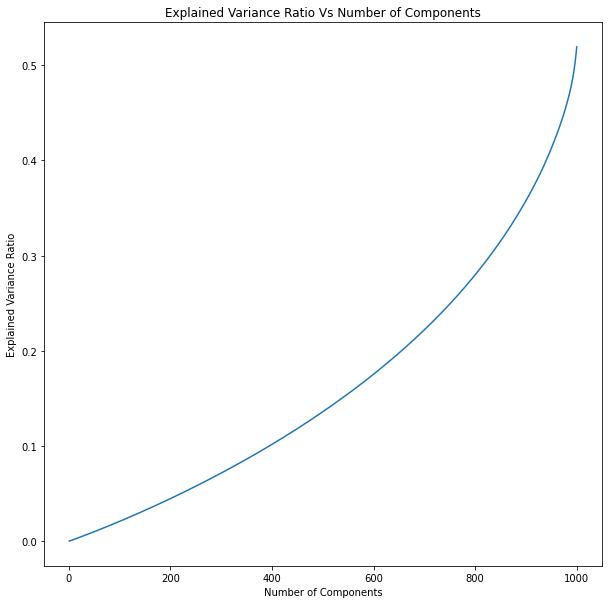

In [ ]:
'''Here we are plotting the explained variance ratio against the number of components.
We notice that choosing 1000 words out of 30k explains more than 50% of the data.
We plan to tune the num_components while training our ML model.'''
var = sorted(lsa.explained_variance_ratio_)
n_components = [i for i in range(1,1001)]
plt.figure(figsize=(10,10))
plt.plot(n_components,np.cumsum(var))
plt.title('Explained Variance Ratio Vs Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')



**2. Chi-squared Statistics**



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Bar plot of Chi2 score for each word')

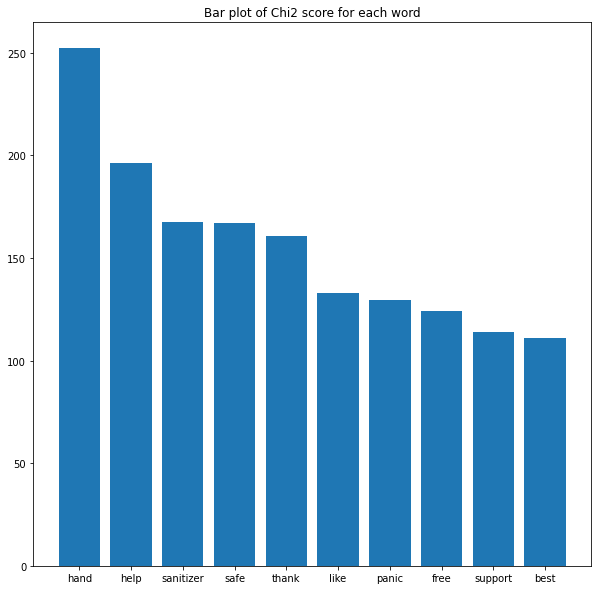

In [ ]:
'''We compute the chi2 scores of features with target variable.
We plot the scores for top 10 words. We reduce the number of
features to a smaller number based on chi2 score'''

chi2score = chi2(X_train_normalize, y_train)[0]
chi2score = zip(chi2score,vectorizer.get_feature_names())
chi2score = sorted(chi2score, key=lambda x:x[0],reverse=True)

top_10 = chi2score[:10]
x = [i for i in range(10)]
top_10_words=[t[1] for t in top_10]
top_10_scores=[t[0] for t in top_10]

plt.figure(figsize=(10,10))
plt.xticks(x, top_10_words)
plt.bar(x,top_10_scores, align='center')
plt.title('Bar plot of Chi2 score for each word')

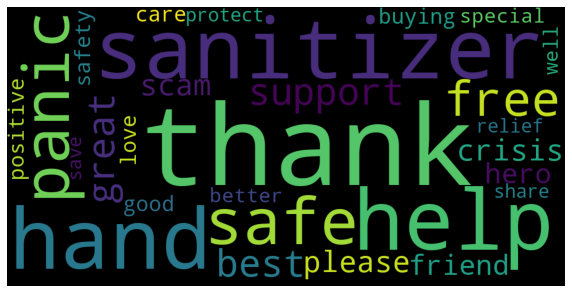

In [ ]:
'''Plotting the 30 words with highest Chi2 scores.
The font size represents the weight of the score.'''

top_30 = chi2score[:30]
top_30_words=[t[1] for t in top_30]
top_30_scores=[t[0] for t in top_30]


normal_words = ' '.join(top_30_words)
wordcloud = WordCloud(width=1000,height=500,max_font_size=200).generate(normal_words)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()



**3. K-means Clustering**



In [ ]:
'''We perform K-means clustering and reduce the number of features to 50 from 30,191
Due to lack of computational resources, we cannot find the optimal k value using the
elbow method. Hence, we reduce it to 50 clusters.'''
kmeans = KMeans(n_clusters = 50).fit(X_train_normalize)
center = kmeans.cluster_centers_

In [ ]:
#Finding the reduced features
v_train =np.zeros((X_train_normalize.shape[0],center.shape[0]))
for i in range(center.shape[0]):
  for j in range(X_train_normalize.shape[0]):
    v_train[j,i]=np.linalg.norm(X_train_normalize[j,:]-center[i,:])

In [ ]:
#Finding inertia for different number of clusters ranging from 1 to 50
inertia = []
for k in range(1,51,5):
  kmeans = KMeans(n_clusters = k).fit(X_train_normalize)
  inertia.append(kmeans.inertia_)

Text(0.5, 1.0, 'Inertia Vs Number of Clusters')

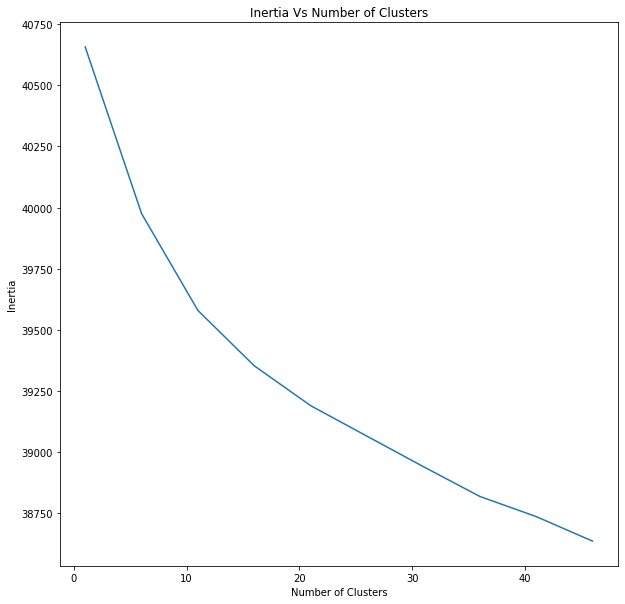

In [ ]:
'''We are plotting the inertia for different number of clusters. We notice
that the inertia reduces as the number of clusters increases'''
num_of_clusters = [k for k in range(1,51,5)]
plt.figure(figsize = (10,10))
plt.plot(num_of_clusters,inertia)
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Inertia Vs Number of Clusters")

In [ ]:
#To ignore warnings 
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#We select features obtained using Chi-square for model classifications
ch2 = SelectKBest(chi2, k=2000)
x_train_chi2_selected = ch2.fit_transform(X_train_normalize, y_train)
x_validation_chi2_selected = ch2.transform(X_test_normalize)

**Model Training and Evaluation**

In [ ]:
def plot_confusion_matrix(y_test,y_pred,ml_model):

  cf_matrix=confusion_matrix(y_test,y_pred)

  group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]

  group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

  labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]

  labels = np.asarray(labels).reshape(2,2)

  ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

  ax.set_title('Confusion Matrix: '+ml_model+'\n');
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values ');

  #Ticket labels - List must be in alphabetical order
  ax.xaxis.set_ticklabels(['Negative','Positive'])
  ax.yaxis.set_ticklabels(['Negative','Positive'])

  #Display the visualization of the Confusion Matrix.
  plt.show()

**1. Naive Bayes**

              precision    recall  f1-score   support

           0       0.82      0.87      0.84      2252
           1       0.79      0.72      0.75      1546

    accuracy                           0.81      3798
   macro avg       0.80      0.79      0.80      3798
weighted avg       0.81      0.81      0.81      3798



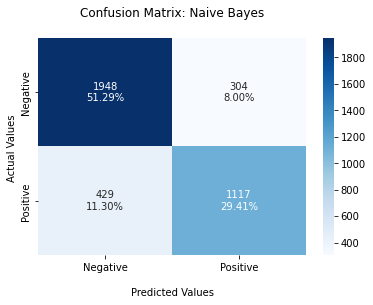

In [ ]:
BNBmodel = BernoulliNB()
BNBmodel.fit(x_train_chi2_selected, y_train)
y_pred = BNBmodel.predict(x_validation_chi2_selected)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(y_test,y_pred,'Naive Bayes')

**2. Logistic Regression**

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      2252
           1       0.85      0.85      0.85      1546

    accuracy                           0.88      3798
   macro avg       0.87      0.87      0.87      3798
weighted avg       0.88      0.88      0.88      3798



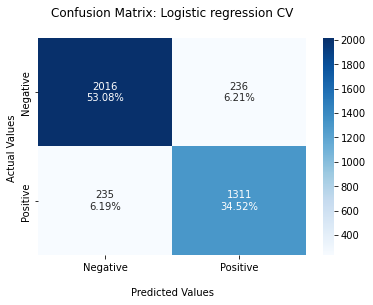

In [ ]:
lr = LogisticRegressionCV(Cs = 100, cv = 5)
lr.fit(x_train_chi2_selected, y_train)
y_pred_lr = lr.predict(x_validation_chi2_selected)
print(classification_report(y_test, y_pred_lr))
plot_confusion_matrix(y_test, y_pred_lr,'Logistic regression CV')

In [ ]:
lr.get_params()

{'Cs': 100,
 'class_weight': None,
 'cv': 5,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1.0,
 'l1_ratios': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'refit': True,
 'scoring': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0}

**Visualizing feature importance from the trained Logistic Regression Model**

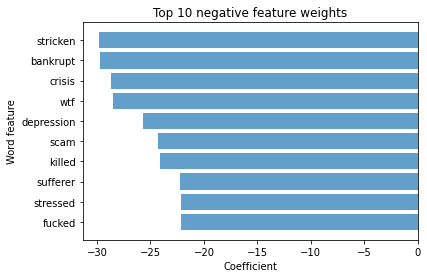

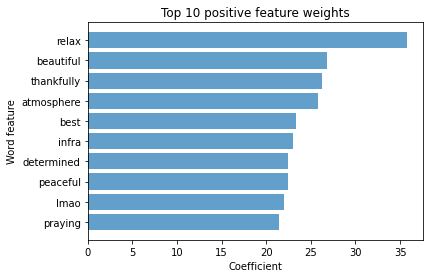

In [ ]:
#list of booleans of selected features
mask = ch2.get_support() 
new_features = [] 

for bool, feature in zip(mask, vectorizer.get_feature_names()):
    if bool:
      new_features.append(feature)
importance = lr.coef_[0]

#Top 10 features with negative weights
top_features=[]
top_scores=[]
n=0
for i,(score,name) in enumerate(sorted(zip(importance,new_features))):
  top_features.append(name)
  top_scores.append(score)
  n+=1
  if(n==10):
    break

#Bar plot
plt.barh(top_features[::-1],top_scores[::-1], align='center', alpha=0.7)
plt.xlabel('Coefficient')
plt.ylabel('Word feature')
plt.title('Top 10 negative feature weights')
plt.show()

#Top 10 positive feature weights
top_features=[]
top_scores=[]
n=0
for i,(score,name) in enumerate(sorted(zip(importance,new_features),reverse=True)):
  top_features.append(name)
  top_scores.append(score)
  n+=1
  if(n==10):
    break

#Plot feature importance, bar plot
plt.barh(top_features[::-1],top_scores[::-1], align='center',alpha=0.7)
plt.xlabel('Coefficient')
plt.ylabel('Word feature')
plt.title('Top 10 positive feature weights')
plt.show()

**3. Random Forest Classifier**

              precision    recall  f1-score   support

           0       0.87      0.80      0.83      2252
           1       0.74      0.82      0.78      1546

    accuracy                           0.81      3798
   macro avg       0.80      0.81      0.80      3798
weighted avg       0.81      0.81      0.81      3798



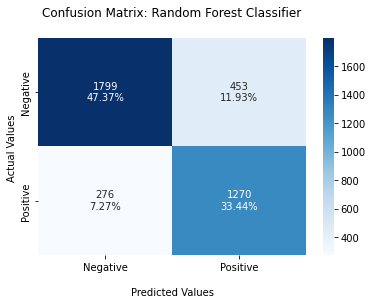

In [ ]:
rf = RandomForestClassifier(n_estimators = 200)
rf.fit(x_train_chi2_selected, y_train)
y_pred_rf = rf.predict(x_validation_chi2_selected)
print(classification_report(y_test, y_pred_rf))
plot_confusion_matrix(y_test,y_pred_rf,'Random Forest Classifier')

**4. Multi-layer Perceptron**

              precision    recall  f1-score   support

           0       0.88      0.87      0.88      2252
           1       0.82      0.83      0.83      1546

    accuracy                           0.86      3798
   macro avg       0.85      0.85      0.85      3798
weighted avg       0.86      0.86      0.86      3798



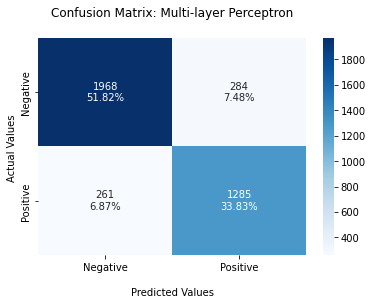

In [ ]:
mlp=MLPClassifier(alpha=1e-3,hidden_layer_sizes=(250,2), random_state=1)
mlp.fit(x_train_chi2_selected, y_train)
y_pred_mlp = mlp.predict(x_validation_chi2_selected)
print(classification_report(y_test, y_pred_mlp))
plot_confusion_matrix(y_test,y_pred_mlp,'Multi-layer Perceptron')